# Vb - Supervised Subsampling with CAFI data
##### Using the outputs from Script 5a, the change probability is then divided into 3 strata, which are proportionally sampled for validation
##### You can use this script to export samples as csv to create your own CEO project
##### This may be run with an m4 instance
###### For more information contact aurelie.shapiro@fao.org or remi.dannunzio@fao.org

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
import uuid
from matplotlib import pyplot as plt

from sampling_handler.misc import py_helpers
from sampling_handler.ensemble import classification as clf
from sampling_handler.ensemble import helpers as h
from sampling_handler.sampling import sfc
from sampling_handler import KMeansSubSampling


import geopandas
import rasterio
import matplotlib.pyplot as plt
from shapely.geometry import Point

/usr/local/share/jupyter/kernels/venv-eSBAE_notebooks/venv/lib/python3.8/site-packages/bfast/__init__.py:10: UserWarning: cupy is not available in this environment, GPU fonctionnalities won't be available
  warn("cupy is not available in this environment, GPU fonctionnalities won't be available")


### read output file from script 5a

In [2]:
esbae_points = pd.read_csv('/home/sepal-user/module_results/esbae/GAB/GAB_esbae_2015_2022_model.csv')
len(esbae_points)

222878

In [3]:
esbae_points.columns

Index(['images', 'mon_images', 'bfast_change_date', 'bfast_magnitude',
       'bfast_means', 'cusum_change_date', 'cusum_confidence',
       'cusum_magnitude', 'red_mean', 'red_sd', 'red_min', 'red_max',
       'nir_mean', 'nir_sd', 'nir_min', 'nir_max', 'swir1_mean', 'swir1_sd',
       'swir1_min', 'swir1_max', 'swir2_mean', 'swir2_sd', 'swir2_min',
       'swir2_max', 'ndfi_mean', 'ndfi_sd', 'ndfi_min', 'ndfi_max',
       'brightness_mean', 'brightness_sd', 'brightness_min', 'brightness_max',
       'greenness_mean', 'greenness_sd', 'greenness_min', 'greenness_max',
       'wetness_mean', 'wetness_sd', 'wetness_min', 'wetness_max',
       'bs_slope_mean', 'bs_slope_sd', 'bs_slope_max', 'bs_slope_min',
       'ccdc_change_date', 'ccdc_magnitude', 'aspect', 'dw_class_mode',
       'dw_tree_prob__max', 'dw_tree_prob__min', 'dw_tree_prob__stdDev',
       'dw_tree_prob_mean', 'elevation', 'esa_lc20', 'esa_lc21', 'esri_lc17',
       'esri_lc18', 'esri_lc19', 'esri_lc20', 'esri_lc21', 'gfc_

In [4]:
# Create a geometry column with Point objects
geometry = [Point(lon, lat) for lon, lat in zip(esbae_points['LON'], esbae_points['LAT'])]

# Create a GeoDataFrame by combining the DataFrame with the geometry
gdf = gpd.GeoDataFrame(esbae_points, geometry=geometry)

# Print the GeoDataFrame
#print(gdf)

In [5]:
joined_df = gdf

### Stratify with Kmeans and select the number of points you want to sample for validation with CEO

In [6]:
sample_size_no = 10000

In [7]:
joined_df, samples = h.kmeans_stratifier(joined_df, 'chg_prob', strata=3, sample_size=sample_size_no)

In [8]:
joined_df['kmeans'] = joined_df['stratum']

,Nh,mean,SD,div,stratum,neyman,proportional
0,172836,0.046728,0.030893,5339.413550,1,3001,3877
1,39981,0.178472,0.058262,2329.361309,2,1309,896
2,10061,0.480221,0.121883,1226.265336,3,689,225


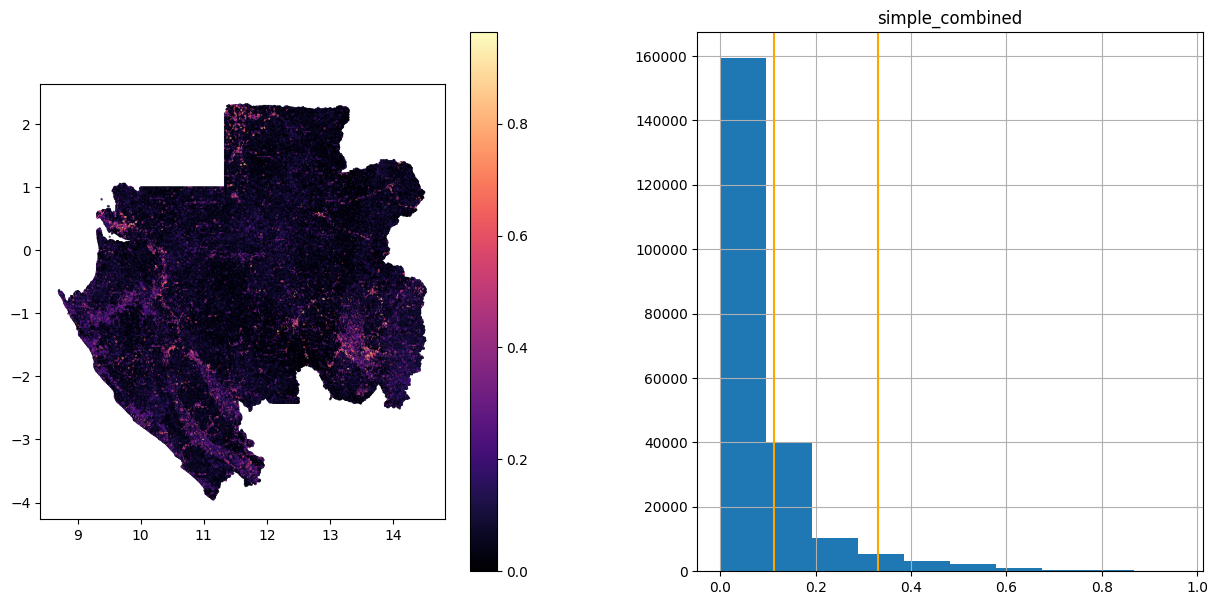

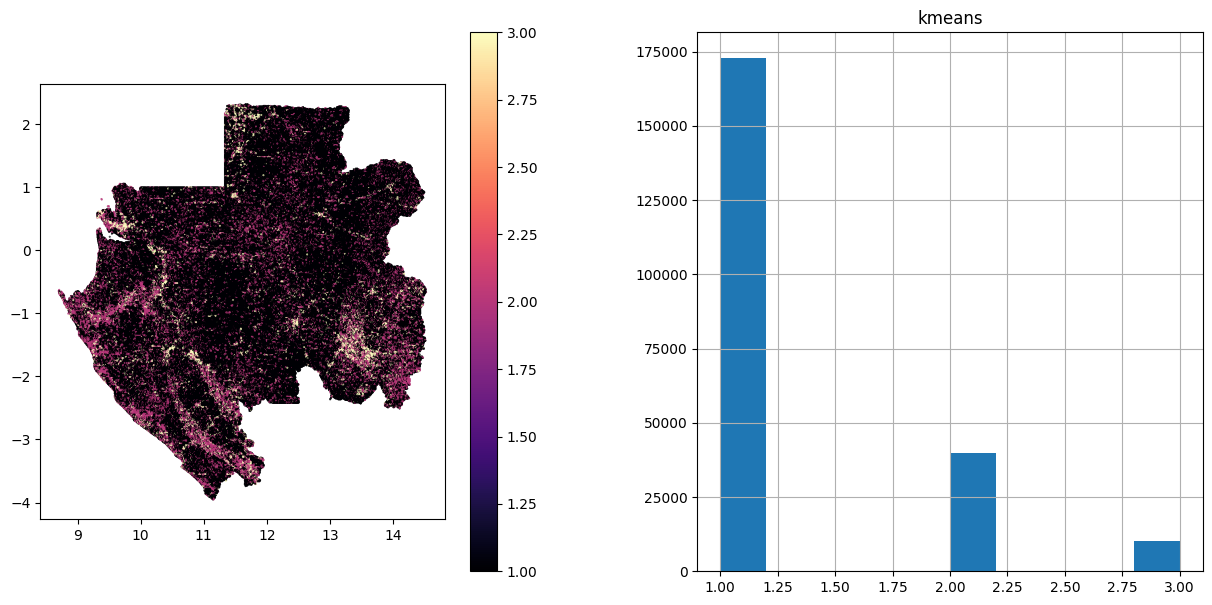

In [9]:
joined_df, sample_df = h.kmeans_stratifier(joined_df, 'chg_prob', strata=3, sample_size=5000)
h.plot_cluster(joined_df, prob_column='simple_combined', strata_column='kmeans')

fig, ax = plt.subplots(1,2, figsize=(15,7))

joined_df.plot('kmeans', markersize=0.15, ax=ax[0], legend=True, cmap='magma')
joined_df.hist('kmeans', ax=ax[1])
sample_df

In [10]:
from sampling_handler.sampling import sfc

def select_with_space_filling_curve(test_df, samples, strata_column='kmeans'):
    dfs = []
    for stratum in test_df[strata_column].unique():
        print(stratum)
        dfs.append(sfc.sfc_subsample(
            gdf = test_df[test_df[strata_column] == stratum],
            target_point_size = samples.neyman[samples.stratum == stratum].values[0]
        ))
        
    return pd.concat(dfs)

samples = select_with_space_filling_curve(joined_df, samples) 

1
2
3


#### plot a map of the points

<Axes: >

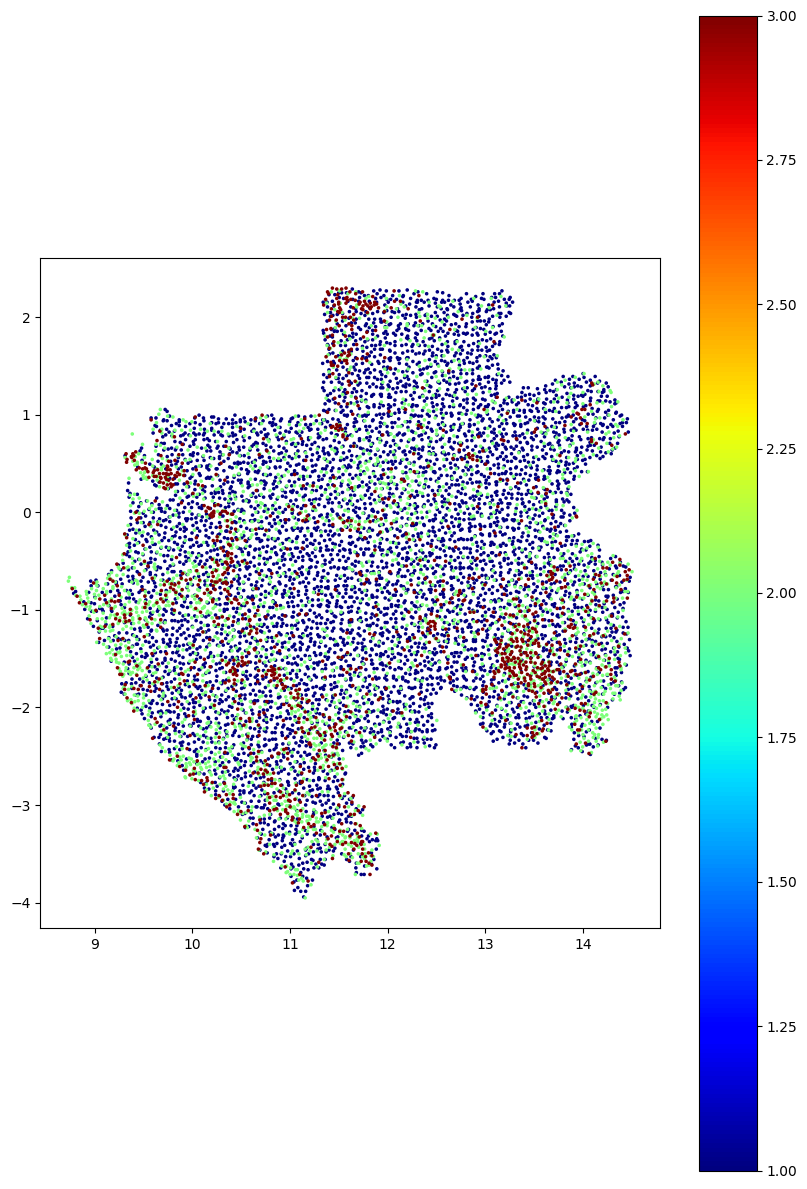

In [11]:
samples.plot('kmeans', markersize=2.5, cmap='jet', legend=True, figsize=(10,15))

### align column names, get coordinates and randomize plotids for CEO


In [12]:
joined_df['PLOTID'] = joined_df['point_id']

In [13]:
joined_df['LON'] = joined_df.geometry.apply(lambda p: p.x)
joined_df['LAT'] = joined_df.geometry.apply(lambda p: p.y)

#### we want plotids in random order for CEO

In [14]:
joined_df = joined_df.sample(frac=1).reset_index(drop=True)
joined_df = joined_df.rename(columns={"PLOTID": "OLD_PLOTID"})
start_id = joined_df["OLD_PLOTID"].max() + 1
joined_df["PLOTID"] = range(start_id, start_id + len(joined_df))

In [15]:
# if you want to export to QGIS
#samples.drop(['ts', 'dates','geometry_x','geometry_y'], axis=1).to_file('gabon_esbae_points_v1.gpkg', driver='GPKG')
#samples.to_file('cog_esbae_points_v1.gpkg', driver='GPKG')

In [16]:
len(samples)

9998

In [17]:
samples.head()

,index,images,mon_images,bfast_change_date,bfast_magnitude,bfast_means,cusum_change_date,cusum_confidence,cusum_magnitude,red_mean,...,point_id,cnc_1520,chg_prob,simple_combined,stratum,kmeans,PLOTID,LON,LAT,dist
28,185147,110,83,2018.578,354.553162,1.388498,2021.140,0.412843,2057.124441,9939.918789,...,53123,NaN,0.056000,0.056000,1,1,53123,9.681418,-2.451119,161341929
56,173991,41,27,2016.192,14677.949219,4.112495,2017.921,0.123825,6685.802469,9468.401235,...,56586,NaN,0.102667,0.102667,1,1,56586,9.761142,-2.431802,162019485
85,173996,52,40,2016.455,137.054962,-1.152537,2020.288,0.194665,6201.350000,9396.070833,...,57579,NaN,0.081333,0.081333,1,1,57579,9.766028,-2.460697,162414154
114,183038,96,76,2022.455,-557.836792,-0.778475,2023.068,0.133840,3450.030263,9443.424123,...,60563,NaN,0.025333,0.025333,1,1,60563,9.785700,-2.537740,163476402
143,190605,71,50,2016.129,-10753.500977,-6.838752,2017.178,0.008160,35963.678333,542.505000,...,69689,NaN,0.098000,0.098000,1,1,69689,9.909889,-2.643597,169984611


In [18]:
samples.columns

Index(['index', 'images', 'mon_images', 'bfast_change_date', 'bfast_magnitude',
       'bfast_means', 'cusum_change_date', 'cusum_confidence',
       'cusum_magnitude', 'red_mean', 'red_sd', 'red_min', 'red_max',
       'nir_mean', 'nir_sd', 'nir_min', 'nir_max', 'swir1_mean', 'swir1_sd',
       'swir1_min', 'swir1_max', 'swir2_mean', 'swir2_sd', 'swir2_min',
       'swir2_max', 'ndfi_mean', 'ndfi_sd', 'ndfi_min', 'ndfi_max',
       'brightness_mean', 'brightness_sd', 'brightness_min', 'brightness_max',
       'greenness_mean', 'greenness_sd', 'greenness_min', 'greenness_max',
       'wetness_mean', 'wetness_sd', 'wetness_min', 'wetness_max',
       'bs_slope_mean', 'bs_slope_sd', 'bs_slope_max', 'bs_slope_min',
       'ccdc_change_date', 'ccdc_magnitude', 'aspect', 'dw_class_mode',
       'dw_tree_prob__max', 'dw_tree_prob__min', 'dw_tree_prob__stdDev',
       'dw_tree_prob_mean', 'elevation', 'esa_lc20', 'esa_lc21', 'esri_lc17',
       'esri_lc18', 'esri_lc19', 'esri_lc20', 'esri_lc2

In [19]:
samples_cols = ['PLOTID','LON', 'LAT', 'index', 'images', 'mon_images', 'bfast_change_date',
       'bfast_magnitude', 'bfast_means', 'cusum_change_date',
       'cusum_confidence', 'cusum_magnitude', 'red_mean', 'red_sd', 'red_min',
       'red_max', 'nir_mean', 'nir_sd', 'nir_min', 'nir_max', 'swir1_mean',
       'swir1_sd', 'swir1_min', 'swir1_max', 'swir2_mean', 'swir2_sd',
       'swir2_min', 'swir2_max', 'ndfi_mean', 'ndfi_sd', 'ndfi_min',
       'ndfi_max', 'brightness_mean', 'brightness_sd', 'brightness_min',
       'brightness_max', 'greenness_mean', 'greenness_sd', 'greenness_min',
       'greenness_max', 'wetness_mean', 'wetness_sd', 'wetness_min',
       'wetness_max', 'bs_slope_mean', 'bs_slope_sd', 'bs_slope_max',
       'bs_slope_min', 'ccdc_change_date', 'ccdc_magnitude', 'aspect',
       'dw_class_mode', 'dw_tree_prob__max', 'dw_tree_prob__min',
       'dw_tree_prob__stdDev', 'dw_tree_prob_mean', 'elevation', 'esa_lc20',
       'esa_lc21', 'esri_lc17', 'esri_lc18', 'esri_lc19', 'esri_lc20',
       'esri_lc21', 'gfc_gain', 'gfc_loss', 'gfc_lossyear', 'gfc_tc00',
       'lang_tree_height', 'potapov_tree_height', 'slope', 'tmf_2016',
       'tmf_2017', 'tmf_2018', 'tmf_2019', 'tmf_2020', 'tmf_defyear',
       'tmf_degyear', 'tmf_main', 'tmf_sub', 'point_id',
       'cnc_1520', 'chg_prob', 'simple_combined', 'kmeans', 'dist', 'Strata'
       ]

### only export first batch of samples once!

In [20]:
# export data to .csv
#samples_out_file =  '/home/sepal-user/module_results/esbae/CAR/car_esbae_samples_v1.csv'
#samples[samples_cols].to_csv(samples_out_file,index=False)

### this section is for adding new samples from strata 2 and 3 to intensify visual interprestation in change areas, while avoiding any duplicates with batch 1
#### this is only relevant if you have already completed the first CEO data collection and wish to add more CEO projects to reduce uncertainties

### load any other samples

In [ ]:
batch1 = pd.read_csv('/home/sepal-user/module_results/esbae/EQG/eqg_esbae_samples_v1.csv')
len(batch1["PLOTID"])

In [ ]:
batch1 = batch1.rename(columns={'Strata': 'stratum'})

In [ ]:
batch1.columns

In [ ]:
#selection = samples[]
#set() in set()
doublon = set(samples["point_id"]).intersection(batch1["point_id"])
np.unique(doublon, return_counts=True)
len(doublon)

In [ ]:
np.unique(samples["stratum"], return_counts=True)

#### if there are batches already join them all

In [ ]:
batch2 = pd.read_csv('/home/sepal-user/module_results/esbae/GAB/gab_esbae_samples_v2.csv')
len(batch2["PLOTID"])

In [ ]:
batch2 = batch2.rename(columns={'Strata': 'stratum'})

In [ ]:
merged_batch = pd.concat([batch1, batch2])
#merged_batch = pd.concat([batch1, batch2,batch3, batch4, batch5])
len(merged_batch)

In [ ]:
merged_batch.columns

In [ ]:
#for 2 batches
#selection = samples[]
#set() in set()
doublon = set(samples["PLOTID"]).intersection(merged_batch["PLOTID"])
np.unique(doublon, return_counts=True)
len(doublon)

#### check for duplicates with previous batches and remove them

In [ ]:
selection = samples[samples["stratum"] > 1]
len(selection)

In [ ]:
sel_ids = set(selection["point_id"]) - set(merged_batch["point_id"])
len(sel_ids)

In [ ]:
doublon = set(selection["point_id"]).intersection(sel_ids)
len(doublon)

In [ ]:
doublon = set(batch1["point_id"]).intersection(sel_ids)
len(doublon)

In [ ]:
sel_final = selection[selection["point_id"].isin(sel_ids)]

In [ ]:
len(sel_final)

In [ ]:
sel_final.head()

#### export a new batch of samples for CEO

In [ ]:
#give a new name to the samples (v2, v3 etc...)
samples_out_file =  '/home/sepal-user/module_results/esbae/EQG/eqg_esbae_samples_v2.csv'
sel_final.to_csv(samples_out_file,index=False)